In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
from itertools import product
import re
from Bio import SeqIO
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")


Libraries imported successfully


In [ ]:

# Load the aromatic_hybrid_3.0_designs.csv file
df_3_0 = pd.read_csv('aromatic_hybrid_3.0_designs.csv')

print(f"Loaded aromatic_hybrid_3.0_designs.csv with shape: {df_3_0.shape}")
print(f"\nColumn names: {df_3_0.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_3_0.head())


Loaded aromatic_hybrid_3.0_designs.csv with shape: (564, 7)

Column names: ['Scaffold', 'Parent_Motif', 'Motif', 'Third_Mutation', 'Third_Mut_Type', 'Design_Sequence', 'Contact_Masked_MJ_Score']

First few rows:
  Scaffold Parent_Motif      Motif Third_Mutation Third_Mut_Type  \
0     2QMT    WQCLICILI  WWCLICILI            Q2W       aromatic   
1     1TEN    WQCLICILI  WWCLICILI            Q2W       aromatic   
2     1FNA    WQCLICILI  WWCLICILI            Q2W       aromatic   
3     1TEN    IQCLWCLII  IWCLWCLII            Q2W       aromatic   
4     2QMT    IQCLWCLII  IWCLWCLII            Q2W       aromatic   

                                     Design_Sequence  Contact_Masked_MJ_Score  
0       MIEKKIEKLEEHLGLAWWCLICILIQKTQPGVSVGVKPFRFGGQ                   572.74  
1                         GSDTITNATIKVQAWWCLICILIKVV                   572.74  
2  MQYKLILNGKTLKGETTTEWWCLICILIVFKQYANDNGVDGVWTYD...                   572.74  
3                         GSDTITNATIKVQAIWCLWCLIIKVV       

In [ ]:

# Identify the top 5 unique 9-mer motifs with the most favorable (most negative) scores
# Most favorable = most negative Contact_Masked_MJ_Score

# Get unique motifs and their best scores
motif_scores = df_3_0.groupby('Motif')['Contact_Masked_MJ_Score'].min().reset_index()
motif_scores = motif_scores.sort_values('Contact_Masked_MJ_Score', ascending=True)

print(f"Total unique motifs in 3.0 library: {len(motif_scores)}")
print(f"\nTop 10 motifs with most favorable (most negative) scores:")
print(motif_scores.head(10))

# Select top 5 motifs
top_5_motifs = motif_scores.head(5)['Motif'].tolist()
print(f"\n=== Top 5 Parent Motifs Selected for 4.0 Generation ===")
for i, motif in enumerate(top_5_motifs, 1):
    score = motif_scores[motif_scores['Motif'] == motif]['Contact_Masked_MJ_Score'].values[0]
    print(f"{i}. {motif} (Score: {score:.2f})")


Total unique motifs in 3.0 library: 188

Top 10 motifs with most favorable (most negative) scores:
         Motif  Contact_Masked_MJ_Score
28   IQCLLCYII                   545.22
47   IQCLYCLII                   545.22
82   LQCLICIYI                   545.22
185  YQCLICLII                   545.22
184  YQCLICILI                   545.22
49   IQCMWCLII                   548.25
98   LQCMICIWI                   548.25
48   IQCMLCWII                   548.25
165  WQCMICLII                   548.25
164  WQCMICILI                   548.25

=== Top 5 Parent Motifs Selected for 4.0 Generation ===
1. IQCLLCYII (Score: 545.22)
2. IQCLYCLII (Score: 545.22)
3. LQCLICIYI (Score: 545.22)
4. YQCLICLII (Score: 545.22)
5. YQCLICILI (Score: 545.22)


In [ ]:

# For each top motif, identify which positions have been mutated from its parent
# We need to extract parent information and trace mutation history

# Let's examine the parent information for our top 5 motifs
print("=== Analyzing mutation history for top 5 motifs ===\n")

for motif in top_5_motifs:
    motif_rows = df_3_0[df_3_0['Motif'] == motif]
    parent_motif = motif_rows['Parent_Motif'].iloc[0]
    third_mutation = motif_rows['Third_Mutation'].iloc[0]
    
    print(f"Motif: {motif}")
    print(f"  Parent (2.0): {parent_motif}")
    print(f"  Third mutation: {third_mutation}")
    
    # Identify differences between parent and current motif
    diffs = []
    for i, (p_aa, m_aa) in enumerate(zip(parent_motif, motif), start=1):
        if p_aa != m_aa:
            diffs.append(f"{p_aa}{i}{m_aa}")
    
    print(f"  All differences from parent: {', '.join(diffs)}")
    print()


=== Analyzing mutation history for top 5 motifs ===

Motif: IQCLLCYII
  Parent (2.0): IQCLLCWII
  Third mutation: W7Y
  All differences from parent: W7Y

Motif: IQCLYCLII
  Parent (2.0): IQCLWCLII
  Third mutation: W5Y
  All differences from parent: W5Y

Motif: LQCLICIYI
  Parent (2.0): LQCLICIWI
  Third mutation: W8Y
  All differences from parent: W8Y

Motif: YQCLICLII
  Parent (2.0): WQCLICLII
  Third mutation: W1Y
  All differences from parent: W1Y

Motif: YQCLICILI
  Parent (2.0): WQCLICILI
  Third mutation: W1Y
  All differences from parent: W1Y



In [ ]:

# We need to trace back the full mutation history
# Each 3.0 motif came from a 2.0 motif, which came from a 1.0 motif (original CDR)
# We need to identify ALL mutated positions so we can mutate non-mutated positions

# Let's examine the parent motifs to understand the full mutation history
# We need to find the original CDR sequences that these are derived from

# First, let's check the parent motifs for the top 5
parent_motifs_set = set()
for motif in top_5_motifs:
    motif_rows = df_3_0[df_3_0['Motif'] == motif]
    parent_motif = motif_rows['Parent_Motif'].iloc[0]
    parent_motifs_set.add(parent_motif)

print(f"Parent motifs (2.0 generation) for our top 5:")
for pm in sorted(parent_motifs_set):
    print(f"  {pm}")

# Let's check what parent motifs exist in the entire 3.0 library
# to understand the naming/tracking system
all_parents = df_3_0['Parent_Motif'].unique()
print(f"\nTotal unique parent motifs in 3.0 library: {len(all_parents)}")
print(f"Sample of parent motifs:")
for pm in sorted(all_parents)[:10]:
    print(f"  {pm}")


Parent motifs (2.0 generation) for our top 5:
  IQCLLCWII
  IQCLWCLII
  LQCLICIWI
  WQCLICILI
  WQCLICLII

Total unique parent motifs in 3.0 library: 5
Sample of parent motifs:
  IQCLLCWII
  IQCLWCLII
  LQCLICIWI
  WQCLICILI
  WQCLICLII


In [ ]:

# Now we need to understand the full mutation history
# The 2.0 parent motifs came from 1.0 (which likely came from original CDRs)
# We need to load the allosteric CDR library to find the original sequences

allosteric_cdrs = pd.read_csv('allosteric_cdr_library.csv')
print("Allosteric CDR Library:")
print(allosteric_cdrs)

# Check which CDRs are 9 amino acids long (since our motifs are 9-mers)
print("\n9-mer CDRs:")
nine_mer_cdrs = allosteric_cdrs[allosteric_cdrs['Sequence'].str.len() == 9]
print(nine_mer_cdrs)


Allosteric CDR Library:
           CDR_ID Antibody   PDB Chain CDR_Type      Sequence  Length
0   7TXZ_E_CDR-H1   nAH1.3  7TXZ     E   CDR-H1      GFSFSYYW       8
1   7TXZ_E_CDR-H2   nAH1.3  7TXZ     E   CDR-H2      IRLKSNNY       8
2   7TXZ_E_CDR-H3   nAH1.3  7TXZ     E   CDR-H3   IYYCTRVITTV      11
3   7TXZ_H_CDR-H1   nAH1.3  7TXZ     H   CDR-H1      GFSFSYYW       8
4   7TXZ_H_CDR-H2   nAH1.3  7TXZ     H   CDR-H2      IRLKSNNY       8
5   7TXZ_H_CDR-H3   nAH1.3  7TXZ     H   CDR-H3   IYYCTRVITTV      11
6   7TXZ_F_CDR-L1   nAH1.3  7TXZ     F   CDR-L1  ASESVHDYGISF      12
7   7TXZ_F_CDR-L2   nAH1.3  7TXZ     F   CDR-L2      LIYSASNQ       8
8   7TXZ_F_CDR-L3   nAH1.3  7TXZ     F   CDR-L3    YFCQQSKEVP      10
9   7TXZ_L_CDR-L1   nAH1.3  7TXZ     L   CDR-L1  RASESVHDYGIS      12
10  7TXZ_L_CDR-L2   nAH1.3  7TXZ     L   CDR-L2      LLIYSASN       8
11  7TXZ_L_CDR-L3   nAH1.3  7TXZ     L   CDR-L3    MYFCQQSKEV      10
12  7TY0_J_CDR-H1     41-6  7TY0     J   CDR-H1      FSFSYYWM     

In [ ]:

# Since there are no 9-mer CDRs in the allosteric library, these motifs were likely
# derived by truncation or extracted from longer CDRs. 
# The key insight is that the 3.0 library has only 5 parent motifs from the 2.0 generation.

# To determine which positions have been mutated across all generations, we need to
# understand the mutation history. Let's analyze the pattern:
# - Each 3.0 motif differs from its 2.0 parent by exactly 1 position (the "third mutation")
# - The 2.0 parents likely differ from some 1.0/original sequence by 2 positions

# For the 4.0 generation, we need to identify positions that have NOT been mutated yet
# Let's assume the 2.0 parents are double mutants from some original sequence

# Strategy: For each top 5 motif (3.0 generation = triple mutants), we need to:
# 1. Identify all 3 positions that were mutated to create it
# 2. Generate fourth mutations at the remaining 6 unmutated positions

# First, let's manually trace the mutation pattern by examining parent motifs
# and looking for patterns in the naming/mutation types

print("=== Detailed analysis of top 5 motifs ===\n")
for motif in top_5_motifs:
    motif_df = df_3_0[df_3_0['Motif'] == motif].iloc[0]
    parent = motif_df['Parent_Motif']
    third_mut = motif_df['Third_Mutation']
    
    print(f"Motif: {motif}")
    print(f"Parent: {parent}")
    print(f"Third mutation: {third_mut}")
    
    # Compare parent to motif to find the third mutation position
    for i, (p, m) in enumerate(zip(parent, motif), start=1):
        if p != m:
            print(f"  Position {i}: {p} -> {m} (Third mutation)")
    
    # Now we need to infer what the original (1.0) sequence was
    # Since the parent is a 2.0 (double mutant), it has 2 mutations from original
    # We need to identify which positions in the parent are mutated
    print()


=== Detailed analysis of top 5 motifs ===

Motif: IQCLLCYII
Parent: IQCLLCWII
Third mutation: W7Y
  Position 7: W -> Y (Third mutation)

Motif: IQCLYCLII
Parent: IQCLWCLII
Third mutation: W5Y
  Position 5: W -> Y (Third mutation)

Motif: LQCLICIYI
Parent: LQCLICIWI
Third mutation: W8Y
  Position 8: W -> Y (Third mutation)

Motif: YQCLICLII
Parent: WQCLICLII
Third mutation: W1Y
  Position 1: W -> Y (Third mutation)

Motif: YQCLICILI
Parent: WQCLICILI
Third mutation: W1Y
  Position 1: W -> Y (Third mutation)



In [ ]:

# Looking at the patterns, all parent motifs contain Q, C, L, I, W amino acids
# and the 3.0 generation has aromatic substitutions (W->Y)
# Let's try to infer the original sequence by looking at common patterns

# All 5 parent motifs share a similar pattern: xQCLxCxII or xQCLxCxIx
# This suggests they may all derive from a common ancestral sequence

# Let's examine if there's a common "base" sequence we can identify
# by looking for the least mutated positions

print("Analyzing parent motif patterns:")
print("\nParent motifs:")
for pm in sorted(parent_motifs_set):
    print(f"  {pm}")

# Looking at these sequences, I notice they all have:
# - Position 2: Q
# - Position 3: C  
# - Position 4: L
# - Position 6: C

# Let's hypothesize that the original sequence might be: IQCLICIII
# or similar, and trace from there

# However, without explicit mutation history, I'll take a pragmatic approach:
# For the 4.0 generation, I'll identify which positions are already mutated
# in each 3.0 motif by finding positions that differ from a "canonical" pattern

# Strategy: For each 3.0 motif, assume it has 3 mutations from original
# The parent (2.0) has 2 mutations, and we added 1 more (the third mutation)
# To identify the first 2 mutations, I need to compare the 2.0 parent against
# a hypothesized original sequence

# Let's look for the most common amino acid at each position across all parent motifs
print("\n\nAmino acid frequency at each position in parent motifs:")
for pos in range(9):
    aas = [pm[pos] for pm in parent_motifs_set]
    print(f"Position {pos+1}: {', '.join(sorted(set(aas)))}")


Analyzing parent motif patterns:

Parent motifs:
  IQCLLCWII
  IQCLWCLII
  LQCLICIWI
  WQCLICILI
  WQCLICLII


Amino acid frequency at each position in parent motifs:
Position 1: I, L, W
Position 2: Q
Position 3: C
Position 4: L
Position 5: I, L, W
Position 6: C
Position 7: I, L, W
Position 8: I, L, W
Position 9: I


In [ ]:

# Based on the analysis, let me infer the original sequence:
# Position 2, 3, 4, 6, 9 are conserved: _QCL_C__I
# Positions 1, 5, 7, 8 vary between I, L, W

# Looking at the most common pattern and the fact that these are aromatic hybrid designs
# (adding aromatic residues like W), I hypothesize the original sequence is: IQCLICIII

# Let's test this hypothesis by comparing each parent motif to IQCLICIII
original_seq = "IQCLICIII"

print(f"Hypothesized original sequence: {original_seq}")
print("\n=== Tracing mutation history ===\n")

mutation_history = {}

for motif in top_5_motifs:
    motif_df = df_3_0[df_3_0['Motif'] == motif].iloc[0]
    parent = motif_df['Parent_Motif']
    third_mut = motif_df['Third_Mutation']
    
    # Find mutations from original to parent (2.0)
    parent_mutations = []
    for i, (orig, par) in enumerate(zip(original_seq, parent), start=1):
        if orig != par:
            parent_mutations.append((i, orig, par))
    
    # Find mutation from parent to motif (3.0)
    motif_mutation = []
    for i, (par, mot) in enumerate(zip(parent, motif), start=1):
        if par != mot:
            motif_mutation.append((i, par, mot))
    
    # All mutated positions (1-indexed)
    all_mutated_positions = set([m[0] for m in parent_mutations] + [m[0] for m in motif_mutation])
    
    # Unmutated positions (for 4th mutation)
    unmutated_positions = [i for i in range(1, 10) if i not in all_mutated_positions]
    
    mutation_history[motif] = {
        'parent': parent,
        'original': original_seq,
        'parent_mutations': parent_mutations,
        'motif_mutation': motif_mutation,
        'all_mutated_positions': sorted(all_mutated_positions),
        'unmutated_positions': unmutated_positions
    }
    
    print(f"Motif: {motif}")
    print(f"  Original: {original_seq}")
    print(f"  Parent:   {parent}")
    print(f"  Current:  {motif}")
    print(f"  Mutations from original to parent (2.0): {parent_mutations}")
    print(f"  Mutation from parent to motif (3.0): {motif_mutation}")
    print(f"  All mutated positions: {sorted(all_mutated_positions)}")
    print(f"  Unmutated positions available for 4th mutation: {unmutated_positions}")
    print()


Hypothesized original sequence: IQCLICIII

=== Tracing mutation history ===

Motif: IQCLLCYII
  Original: IQCLICIII
  Parent:   IQCLLCWII
  Current:  IQCLLCYII
  Mutations from original to parent (2.0): [(5, 'I', 'L'), (7, 'I', 'W')]
  Mutation from parent to motif (3.0): [(7, 'W', 'Y')]
  All mutated positions: [5, 7]
  Unmutated positions available for 4th mutation: [1, 2, 3, 4, 6, 8, 9]

Motif: IQCLYCLII
  Original: IQCLICIII
  Parent:   IQCLWCLII
  Current:  IQCLYCLII
  Mutations from original to parent (2.0): [(5, 'I', 'W'), (7, 'I', 'L')]
  Mutation from parent to motif (3.0): [(5, 'W', 'Y')]
  All mutated positions: [5, 7]
  Unmutated positions available for 4th mutation: [1, 2, 3, 4, 6, 8, 9]

Motif: LQCLICIYI
  Original: IQCLICIII
  Parent:   LQCLICIWI
  Current:  LQCLICIYI
  Mutations from original to parent (2.0): [(1, 'I', 'L'), (8, 'I', 'W')]
  Mutation from parent to motif (3.0): [(8, 'W', 'Y')]
  All mutated positions: [1, 8]
  Unmutated positions available for 4th mutat

In [ ]:

# Define BLOSUM62 matrix for conservative mutations
# BLOSUM62 scoring matrix (simplified for common amino acids)
BLOSUM62 = {
    'A': {'A': 4, 'R': -1, 'N': -2, 'D': -2, 'C': 0, 'Q': -1, 'E': -1, 'G': 0, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 0, 'W': -3, 'Y': -2, 'V': 0},
    'R': {'A': -1, 'R': 5, 'N': 0, 'D': -2, 'C': -3, 'Q': 1, 'E': 0, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 2, 'M': -1, 'F': -3, 'P': -2, 'S': -1, 'T': -1, 'W': -3, 'Y': -2, 'V': -3},
    'N': {'A': -2, 'R': 0, 'N': 6, 'D': 1, 'C': -3, 'Q': 0, 'E': 0, 'G': 0, 'H': 1, 'I': -3, 'L': -3, 'K': 0, 'M': -2, 'F': -3, 'P': -2, 'S': 1, 'T': 0, 'W': -4, 'Y': -2, 'V': -3},
    'D': {'A': -2, 'R': -2, 'N': 1, 'D': 6, 'C': -3, 'Q': 0, 'E': 2, 'G': -1, 'H': -1, 'I': -3, 'L': -4, 'K': -1, 'M': -3, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -4, 'Y': -3, 'V': -3},
    'C': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': 9, 'Q': -3, 'E': -4, 'G': -3, 'H': -3, 'I': -1, 'L': -1, 'K': -3, 'M': -1, 'F': -2, 'P': -3, 'S': -1, 'T': -1, 'W': -2, 'Y': -2, 'V': -1},
    'Q': {'A': -1, 'R': 1, 'N': 0, 'D': 0, 'C': -3, 'Q': 5, 'E': 2, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 1, 'M': 0, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -2, 'Y': -1, 'V': -2},
    'E': {'A': -1, 'R': 0, 'N': 0, 'D': 2, 'C': -4, 'Q': 2, 'E': 5, 'G': -2, 'H': 0, 'I': -3, 'L': -3, 'K': 1, 'M': -2, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'G': {'A': 0, 'R': -2, 'N': 0, 'D': -1, 'C': -3, 'Q': -2, 'E': -2, 'G': 6, 'H': -2, 'I': -4, 'L': -4, 'K': -2, 'M': -3, 'F': -3, 'P': -2, 'S': 0, 'T': -2, 'W': -2, 'Y': -3, 'V': -3},
    'H': {'A': -2, 'R': 0, 'N': 1, 'D': -1, 'C': -3, 'Q': 0, 'E': 0, 'G': -2, 'H': 8, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -1, 'P': -2, 'S': -1, 'T': -2, 'W': -2, 'Y': 2, 'V': -3},
    'I': {'A': -1, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -3, 'E': -3, 'G': -4, 'H': -3, 'I': 4, 'L': 2, 'K': -3, 'M': 1, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -3, 'Y': -1, 'V': 3},
    'L': {'A': -1, 'R': -2, 'N': -3, 'D': -4, 'C': -1, 'Q': -2, 'E': -3, 'G': -4, 'H': -3, 'I': 2, 'L': 4, 'K': -2, 'M': 2, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'K': {'A': -1, 'R': 2, 'N': 0, 'D': -1, 'C': -3, 'Q': 1, 'E': 1, 'G': -2, 'H': -1, 'I': -3, 'L': -2, 'K': 5, 'M': -1, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'M': {'A': -1, 'R': -1, 'N': -2, 'D': -3, 'C': -1, 'Q': 0, 'E': -2, 'G': -3, 'H': -2, 'I': 1, 'L': 2, 'K': -1, 'M': 5, 'F': 0, 'P': -2, 'S': -1, 'T': -1, 'W': -1, 'Y': -1, 'V': 1},
    'F': {'A': -2, 'R': -3, 'N': -3, 'D': -3, 'C': -2, 'Q': -3, 'E': -3, 'G': -3, 'H': -1, 'I': 0, 'L': 0, 'K': -3, 'M': 0, 'F': 6, 'P': -4, 'S': -2, 'T': -2, 'W': 1, 'Y': 3, 'V': -1},
    'P': {'A': -1, 'R': -2, 'N': -2, 'D': -1, 'C': -3, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -4, 'P': 7, 'S': -1, 'T': -1, 'W': -4, 'Y': -3, 'V': -2},
    'S': {'A': 1, 'R': -1, 'N': 1, 'D': 0, 'C': -1, 'Q': 0, 'E': 0, 'G': 0, 'H': -1, 'I': -2, 'L': -2, 'K': 0, 'M': -1, 'F': -2, 'P': -1, 'S': 4, 'T': 1, 'W': -3, 'Y': -2, 'V': -2},
    'T': {'A': 0, 'R': -1, 'N': 0, 'D': -1, 'C': -1, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 5, 'W': -2, 'Y': -2, 'V': 0},
    'W': {'A': -3, 'R': -3, 'N': -4, 'D': -4, 'C': -2, 'Q': -2, 'E': -3, 'G': -2, 'H': -2, 'I': -3, 'L': -2, 'K': -3, 'M': -1, 'F': 1, 'P': -4, 'S': -3, 'T': -2, 'W': 11, 'Y': 2, 'V': -3},
    'Y': {'A': -2, 'R': -2, 'N': -2, 'D': -3, 'C': -2, 'Q': -1, 'E': -2, 'G': -3, 'H': 2, 'I': -1, 'L': -1, 'K': -2, 'M': -1, 'F': 3, 'P': -3, 'S': -2, 'T': -2, 'W': 2, 'Y': 7, 'V': -1},
    'V': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -2, 'E': -2, 'G': -3, 'H': -3, 'I': 3, 'L': 1, 'K': -2, 'M': 1, 'F': -1, 'P': -2, 'S': -2, 'T': 0, 'W': -3, 'Y': -1, 'V': 4}
}

# Define aromatic amino acids
AROMATIC_AAS = ['F', 'W', 'Y', 'H']

print("BLOSUM62 matrix and aromatic amino acids defined")
print(f"Aromatic amino acids: {AROMATIC_AAS}")


BLOSUM62 matrix and aromatic amino acids defined
Aromatic amino acids: ['F', 'W', 'Y', 'H']


In [ ]:

# Generate fourth mutations for each of the top 5 motifs
# For each unmutated position, generate:
# 1. Aromatic substitutions (F, W, Y, H)
# 2. Conservative substitutions (BLOSUM62 score > 0)

print("=== Generating Fourth Mutations ===\n")

fourth_generation_motifs = []

for motif in top_5_motifs:
    history = mutation_history[motif]
    unmutated_positions = history['unmutated_positions']
    
    print(f"Parent motif (3.0): {motif}")
    print(f"  Unmutated positions: {unmutated_positions}")
    
    # For each unmutated position, generate possible mutations
    for pos in unmutated_positions:
        current_aa = motif[pos - 1]  # Convert to 0-indexed
        
        # Generate aromatic mutations
        for aromatic_aa in AROMATIC_AAS:
            if aromatic_aa != current_aa:  # Don't mutate to the same AA
                new_motif = list(motif)
                new_motif[pos - 1] = aromatic_aa
                new_motif_str = ''.join(new_motif)
                
                fourth_generation_motifs.append({
                    'Parent_Motif': motif,
                    'Motif': new_motif_str,
                    'Fourth_Mutation': f"{current_aa}{pos}{aromatic_aa}",
                    'Fourth_Mut_Type': 'aromatic'
                })
        
        # Generate conservative mutations (BLOSUM62 > 0)
        if current_aa in BLOSUM62:
            for target_aa, score in BLOSUM62[current_aa].items():
                if score > 0 and target_aa != current_aa:  # Conservative substitution
                    new_motif = list(motif)
                    new_motif[pos - 1] = target_aa
                    new_motif_str = ''.join(new_motif)
                    
                    fourth_generation_motifs.append({
                        'Parent_Motif': motif,
                        'Motif': new_motif_str,
                        'Fourth_Mutation': f"{current_aa}{pos}{target_aa}",
                        'Fourth_Mut_Type': 'conservative'
                    })
    
    print(f"  Generated mutations: {len([m for m in fourth_generation_motifs if m['Parent_Motif'] == motif])}")
    print()

print(f"\nTotal fourth-generation motifs before filtering: {len(fourth_generation_motifs)}")

# Convert to DataFrame for easier manipulation
df_4_0_motifs = pd.DataFrame(fourth_generation_motifs)
print(f"\nSample of generated motifs:")
print(df_4_0_motifs.head(10))


=== Generating Fourth Mutations ===

Parent motif (3.0): IQCLLCYII
  Unmutated positions: [1, 2, 3, 4, 6, 8, 9]
  Generated mutations: 43

Parent motif (3.0): IQCLYCLII
  Unmutated positions: [1, 2, 3, 4, 6, 8, 9]
  Generated mutations: 43

Parent motif (3.0): LQCLICIYI
  Unmutated positions: [2, 3, 4, 5, 6, 7, 9]
  Generated mutations: 43

Parent motif (3.0): YQCLICLII
  Unmutated positions: [2, 3, 4, 5, 6, 8, 9]
  Generated mutations: 43

Parent motif (3.0): YQCLICILI
  Unmutated positions: [2, 3, 4, 5, 6, 7, 9]
  Generated mutations: 43


Total fourth-generation motifs before filtering: 215

Sample of generated motifs:
  Parent_Motif      Motif Fourth_Mutation Fourth_Mut_Type
0    IQCLLCYII  FQCLLCYII             I1F        aromatic
1    IQCLLCYII  WQCLLCYII             I1W        aromatic
2    IQCLLCYII  YQCLLCYII             I1Y        aromatic
3    IQCLLCYII  HQCLLCYII             I1H        aromatic
4    IQCLLCYII  LQCLLCYII             I1L    conservative
5    IQCLLCYII  MQCLLC

In [ ]:

# Remove duplicate motifs (same motif sequence can be generated from different parents)
print(f"Before removing duplicates: {len(df_4_0_motifs)} entries")

# Keep only unique motifs (keep first occurrence)
df_4_0_motifs_unique = df_4_0_motifs.drop_duplicates(subset='Motif', keep='first')

print(f"After removing duplicates: {len(df_4_0_motifs_unique)} unique motifs")
print(f"\nSample of unique motifs:")
print(df_4_0_motifs_unique.head(10))


Before removing duplicates: 215 entries
After removing duplicates: 213 unique motifs

Sample of unique motifs:
  Parent_Motif      Motif Fourth_Mutation Fourth_Mut_Type
0    IQCLLCYII  FQCLLCYII             I1F        aromatic
1    IQCLLCYII  WQCLLCYII             I1W        aromatic
2    IQCLLCYII  YQCLLCYII             I1Y        aromatic
3    IQCLLCYII  HQCLLCYII             I1H        aromatic
4    IQCLLCYII  LQCLLCYII             I1L    conservative
5    IQCLLCYII  MQCLLCYII             I1M    conservative
6    IQCLLCYII  VQCLLCYII             I1V    conservative
7    IQCLLCYII  IFCLLCYII             Q2F        aromatic
8    IQCLLCYII  IWCLLCYII             Q2W        aromatic
9    IQCLLCYII  IYCLLCYII             Q2Y        aromatic


In [ ]:

# Now graft each motif onto the three scaffolds (1FNA, 1TEN, 2QMT)
# We need to load scaffold sequences and graft the motifs

# Load one example from the 3.0 library to understand the grafting pattern
print("Examining grafting patterns from 3.0 library:\n")

# Get examples for each scaffold
for scaffold in ['1FNA', '1TEN', '2QMT']:
    example = df_3_0[df_3_0['Scaffold'] == scaffold].iloc[0]
    motif = example['Motif']
    full_seq = example['Design_Sequence']
    
    # Find where the motif is in the full sequence
    motif_pos = full_seq.find(motif)
    
    print(f"Scaffold: {scaffold}")
    print(f"  Full sequence length: {len(full_seq)}")
    print(f"  Motif: {motif}")
    print(f"  Motif position: {motif_pos}")
    print(f"  Sequence around motif: ...{full_seq[max(0,motif_pos-5):motif_pos+len(motif)+5]}...")
    print()


Examining grafting patterns from 3.0 library:

Scaffold: 1FNA
  Full sequence length: 56
  Motif: WWCLICILI
  Motif position: 19
  Sequence around motif: ...ETTTEWWCLICILIVFKQY...

Scaffold: 1TEN
  Full sequence length: 26
  Motif: WWCLICILI
  Motif position: 14
  Sequence around motif: ...IKVQAWWCLICILIKVV...

Scaffold: 2QMT
  Full sequence length: 44
  Motif: WWCLICILI
  Motif position: 16
  Sequence around motif: ...HLGLAWWCLICILIQKTQP...



In [ ]:

# Extract scaffold templates from the 3.0 library
# We need to get the scaffold sequence before and after the motif

scaffold_templates = {}

for scaffold in ['1FNA', '1TEN', '2QMT']:
    # Get one example for this scaffold
    example = df_3_0[df_3_0['Scaffold'] == scaffold].iloc[0]
    motif = example['Motif']
    full_seq = example['Design_Sequence']
    
    # Find motif position
    motif_pos = full_seq.find(motif)
    
    # Extract prefix and suffix
    prefix = full_seq[:motif_pos]
    suffix = full_seq[motif_pos + len(motif):]
    
    scaffold_templates[scaffold] = {
        'prefix': prefix,
        'suffix': suffix
    }
    
    print(f"Scaffold {scaffold}:")
    print(f"  Prefix: {prefix}")
    print(f"  Suffix: {suffix}")
    print()

print("Scaffold templates extracted successfully")


Scaffold 1FNA:
  Prefix: MQYKLILNGKTLKGETTTE
  Suffix: VFKQYANDNGVDGVWTYDDATKTFTVTE

Scaffold 1TEN:
  Prefix: GSDTITNATIKVQA
  Suffix: KVV

Scaffold 2QMT:
  Prefix: MIEKKIEKLEEHLGLA
  Suffix: QKTQPGVSVGVKPFRFGGQ

Scaffold templates extracted successfully


In [ ]:

# Generate full design sequences by grafting each motif onto the three scaffolds
print("=== Grafting motifs onto scaffolds ===\n")

full_designs = []

for idx, row in df_4_0_motifs_unique.iterrows():
    motif = row['Motif']
    parent_motif = row['Parent_Motif']
    fourth_mutation = row['Fourth_Mutation']
    fourth_mut_type = row['Fourth_Mut_Type']
    
    # Graft onto each scaffold
    for scaffold in ['1FNA', '1TEN', '2QMT']:
        prefix = scaffold_templates[scaffold]['prefix']
        suffix = scaffold_templates[scaffold]['suffix']
        full_seq = prefix + motif + suffix
        
        full_designs.append({
            'Scaffold': scaffold,
            'Parent_Motif': parent_motif,
            'Motif': motif,
            'Fourth_Mutation': fourth_mutation,
            'Fourth_Mut_Type': fourth_mut_type,
            'Design_Sequence': full_seq
        })

df_4_0_designs = pd.DataFrame(full_designs)

print(f"Total designs before novelty filtering: {len(df_4_0_designs)}")
print(f"Unique motifs: {df_4_0_designs['Motif'].nunique()}")
print(f"Designs per scaffold:")
print(df_4_0_designs['Scaffold'].value_counts().sort_index())
print(f"\nSample of full designs:")
print(df_4_0_designs.head())


=== Grafting motifs onto scaffolds ===

Total designs before novelty filtering: 639
Unique motifs: 213
Designs per scaffold:
Scaffold
1FNA    213
1TEN    213
2QMT    213
Name: count, dtype: int64

Sample of full designs:
  Scaffold Parent_Motif      Motif Fourth_Mutation Fourth_Mut_Type  \
0     1FNA    IQCLLCYII  FQCLLCYII             I1F        aromatic   
1     1TEN    IQCLLCYII  FQCLLCYII             I1F        aromatic   
2     2QMT    IQCLLCYII  FQCLLCYII             I1F        aromatic   
3     1FNA    IQCLLCYII  WQCLLCYII             I1W        aromatic   
4     1TEN    IQCLLCYII  WQCLLCYII             I1W        aromatic   

                                     Design_Sequence  
0  MQYKLILNGKTLKGETTTEFQCLLCYIIVFKQYANDNGVDGVWTYD...  
1                         GSDTITNATIKVQAFQCLLCYIIKVV  
2       MIEKKIEKLEEHLGLAFQCLLCYIIQKTQPGVSVGVKPFRFGGQ  
3  MQYKLILNGKTLKGETTTEWQCLLCYIIVFKQYANDNGVDGVWTYD...  
4                         GSDTITNATIKVQAWQCLLCYIIKVV  


In [ ]:

# Now perform novelty filtering using 10-mer sliding window
# Load all known binder sequences

print("=== Loading Known Binder Sequences ===\n")

# Load FASTA file
known_binders = []
with open('known_niv_binders_full.fasta', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        known_binders.append(str(record.seq))
        
print(f"Loaded {len(known_binders)} sequences from known_niv_binders_full.fasta")

# Load competitive CDR library
competitive_cdrs = pd.read_csv('cdr_library_summary.csv')
for seq in competitive_cdrs['Sequence']:
    known_binders.append(seq)
    
print(f"Added {len(competitive_cdrs)} sequences from cdr_library_summary.csv")

# Load allosteric CDR library (already loaded earlier)
for seq in allosteric_cdrs['Sequence']:
    known_binders.append(seq)
    
print(f"Added {len(allosteric_cdrs)} sequences from allosteric_cdr_library.csv")

print(f"\nTotal known binder sequences: {len(known_binders)}")


=== Loading Known Binder Sequences ===

Loaded 6 sequences from known_niv_binders_full.fasta
Added 12 sequences from cdr_library_summary.csv
Added 21 sequences from allosteric_cdr_library.csv

Total known binder sequences: 39


In [ ]:

# Create a function to extract all 10-mers from a sequence
def get_all_10mers(sequence):
    """Extract all 10-mer subsequences from a sequence."""
    if len(sequence) < 10:
        return []
    return [sequence[i:i+10] for i in range(len(sequence) - 9)]

# Build a set of all 10-mers from known binders
print("Building 10-mer database from known binders...")
known_10mers = set()

for seq in known_binders:
    ten_mers = get_all_10mers(seq)
    known_10mers.update(ten_mers)

print(f"Total unique 10-mers in known binder database: {len(known_10mers)}")
print(f"\nSample of known 10-mers:")
for i, tmer in enumerate(list(known_10mers)[:5]):
    print(f"  {tmer}")


Building 10-mer database from known binders...
Total unique 10-mers in known binder database: 913

Sample of known 10-mers:
  LLNNFYPREA
  NSLQTDDTAI
  VYYCQQYGRS
  SCDKTHHHHH
  REGDWFFDVW


In [ ]:

# Apply novelty filter to all designs
# A design passes if it does NOT contain any 10-mer that matches known binders

def check_novelty(sequence, known_10mers_set):
    """
    Check if a sequence is novel (doesn't contain any known 10-mer).
    Returns True if novel, False if contains a known 10-mer.
    """
    design_10mers = get_all_10mers(sequence)
    for tmer in design_10mers:
        if tmer in known_10mers_set:
            return False
    return True

print("=== Applying Novelty Filter ===\n")
print(f"Filtering {len(df_4_0_designs)} designs...")

# Apply filter
df_4_0_designs['is_novel'] = df_4_0_designs['Design_Sequence'].apply(
    lambda seq: check_novelty(seq, known_10mers)
)

# Count results
novel_count = df_4_0_designs['is_novel'].sum()
rejected_count = len(df_4_0_designs) - novel_count

print(f"\nNovelty filter results:")
print(f"  Novel designs: {novel_count}")
print(f"  Rejected designs: {rejected_count}")
print(f"  Pass rate: {novel_count / len(df_4_0_designs) * 100:.1f}%")

# Keep only novel designs
df_4_0_designs_novel = df_4_0_designs[df_4_0_designs['is_novel']].copy()
df_4_0_designs_novel = df_4_0_designs_novel.drop(columns=['is_novel'])

print(f"\nNovel designs by scaffold:")
print(df_4_0_designs_novel['Scaffold'].value_counts().sort_index())
print(f"\nUnique novel motifs: {df_4_0_designs_novel['Motif'].nunique()}")


=== Applying Novelty Filter ===

Filtering 639 designs...

Novelty filter results:
  Novel designs: 639
  Rejected designs: 0
  Pass rate: 100.0%

Novel designs by scaffold:
Scaffold
1FNA    213
1TEN    213
2QMT    213
Name: count, dtype: int64

Unique novel motifs: 213


In [ ]:

# Now we need to implement the contact-masked MJ scoring function
# This scores the interaction between a motif and the 31-residue allosteric epitope
# using the top 30% most favorable pairwise interactions

# Define the 31-residue allosteric epitope
ALLOSTERIC_EPITOPE_31 = "KGVTPSQIGRLHFNSTGWNVTDKTQCIQKAV"

# Miyazawa-Jernigan potential matrix (contact energies in arbitrary units)
# More negative = more favorable interaction
MJ_MATRIX = {
    'C': {'C': -5.44, 'M': -5.46, 'F': -5.80, 'I': -5.50, 'L': -5.83, 'V': -5.50, 'W': -7.28, 'Y': -6.14, 'A': -5.05, 'G': -4.99, 'T': -4.81, 'S': -4.59, 'N': -4.94, 'Q': -5.05, 'D': -4.81, 'E': -4.86, 'H': -5.29, 'R': -4.59, 'K': -4.46, 'P': -4.36},
    'M': {'C': -5.46, 'M': -5.46, 'F': -5.32, 'I': -5.46, 'L': -5.32, 'V': -4.91, 'W': -4.97, 'Y': -4.91, 'A': -4.99, 'G': -4.81, 'T': -4.99, 'S': -4.59, 'N': -4.36, 'Q': -4.72, 'D': -4.50, 'E': -4.36, 'H': -5.32, 'R': -4.13, 'K': -4.99, 'P': -3.90},
    'F': {'C': -5.80, 'M': -5.32, 'F': -6.84, 'I': -5.88, 'L': -5.80, 'V': -5.59, 'W': -5.66, 'Y': -5.66, 'A': -5.36, 'G': -5.32, 'T': -5.05, 'S': -4.81, 'N': -4.92, 'Q': -5.18, 'D': -5.02, 'E': -5.02, 'H': -5.66, 'R': -4.50, 'K': -5.32, 'P': -4.77},
    'I': {'C': -5.50, 'M': -5.46, 'F': -5.88, 'I': -5.00, 'L': -5.50, 'V': -5.46, 'W': -5.78, 'Y': -5.18, 'A': -4.81, 'G': -4.50, 'T': -4.77, 'S': -4.50, 'N': -4.50, 'Q': -4.72, 'D': -4.13, 'E': -4.50, 'H': -5.00, 'R': -4.72, 'K': -4.77, 'P': -4.03},
    'L': {'C': -5.83, 'M': -5.32, 'F': -5.80, 'I': -5.50, 'L': -5.50, 'V': -5.18, 'W': -5.73, 'Y': -5.25, 'A': -4.91, 'G': -4.77, 'T': -4.77, 'S': -4.59, 'N': -4.72, 'Q': -4.59, 'D': -4.72, 'E': -4.72, 'H': -4.97, 'R': -4.50, 'K': -4.50, 'P': -4.36},
    'V': {'C': -5.50, 'M': -4.91, 'F': -5.59, 'I': -5.46, 'L': -5.18, 'V': -4.96, 'W': -5.73, 'Y': -5.32, 'A': -4.72, 'G': -4.50, 'T': -4.86, 'S': -4.59, 'N': -4.77, 'Q': -4.77, 'D': -4.50, 'E': -4.50, 'H': -5.18, 'R': -4.59, 'K': -4.77, 'P': -4.36},
    'W': {'C': -7.28, 'M': -4.97, 'F': -5.66, 'I': -5.78, 'L': -5.73, 'V': -5.73, 'W': -5.55, 'Y': -5.18, 'A': -5.18, 'G': -5.50, 'T': -5.02, 'S': -4.46, 'N': -4.95, 'Q': -4.50, 'D': -4.75, 'E': -4.32, 'H': -4.77, 'R': -3.98, 'K': -3.36, 'P': -4.25},
    'Y': {'C': -6.14, 'M': -4.91, 'F': -5.66, 'I': -5.18, 'L': -5.25, 'V': -5.32, 'W': -5.18, 'Y': -5.73, 'A': -4.81, 'G': -5.05, 'T': -4.77, 'S': -4.46, 'N': -4.60, 'Q': -4.77, 'D': -4.39, 'E': -4.17, 'H': -5.25, 'R': -4.36, 'K': -4.77, 'P': -3.98},
    'A': {'C': -5.05, 'M': -4.99, 'F': -5.36, 'I': -4.81, 'L': -4.91, 'V': -4.72, 'W': -5.18, 'Y': -4.81, 'A': -3.78, 'G': -4.58, 'T': -4.03, 'S': -4.03, 'N': -4.17, 'Q': -3.90, 'D': -3.98, 'E': -3.90, 'H': -4.72, 'R': -4.36, 'K': -4.50, 'P': -3.07},
    'G': {'C': -4.99, 'M': -4.81, 'F': -5.32, 'I': -4.50, 'L': -4.77, 'V': -4.50, 'W': -5.50, 'Y': -5.05, 'A': -4.58, 'G': -3.63, 'T': -3.98, 'S': -3.98, 'N': -4.13, 'Q': -3.98, 'D': -3.63, 'E': -3.63, 'H': -4.77, 'R': -4.13, 'K': -4.13, 'P': -2.84},
    'T': {'C': -4.81, 'M': -4.99, 'F': -5.05, 'I': -4.77, 'L': -4.77, 'V': -4.86, 'W': -5.02, 'Y': -4.77, 'A': -4.03, 'G': -3.98, 'T': -4.03, 'S': -3.90, 'N': -3.90, 'Q': -4.17, 'D': -3.63, 'E': -3.98, 'H': -4.50, 'R': -3.98, 'K': -3.90, 'P': -3.30},
    'S': {'C': -4.59, 'M': -4.59, 'F': -4.81, 'I': -4.50, 'L': -4.59, 'V': -4.59, 'W': -4.46, 'Y': -4.46, 'A': -4.03, 'G': -3.98, 'T': -3.90, 'S': -3.40, 'N': -3.98, 'Q': -3.63, 'D': -3.40, 'E': -3.63, 'H': -4.32, 'R': -3.98, 'K': -3.98, 'P': -3.07},
    'N': {'C': -4.94, 'M': -4.36, 'F': -4.92, 'I': -4.50, 'L': -4.72, 'V': -4.77, 'W': -4.95, 'Y': -4.60, 'A': -4.17, 'G': -4.13, 'T': -3.90, 'S': -3.98, 'N': -3.90, 'Q': -3.72, 'D': -3.72, 'E': -3.63, 'H': -4.50, 'R': -3.72, 'K': -4.13, 'P': -2.70},
    'Q': {'C': -5.05, 'M': -4.72, 'F': -5.18, 'I': -4.72, 'L': -4.59, 'V': -4.77, 'W': -4.50, 'Y': -4.77, 'A': -3.90, 'G': -3.98, 'T': -4.17, 'S': -3.63, 'N': -3.72, 'Q': -3.53, 'D': -3.98, 'E': -3.53, 'H': -4.59, 'R': -3.72, 'K': -3.63, 'P': -2.70},
    'D': {'C': -4.81, 'M': -4.50, 'F': -5.02, 'I': -4.13, 'L': -4.72, 'V': -4.50, 'W': -4.75, 'Y': -4.39, 'A': -3.98, 'G': -3.63, 'T': -3.63, 'S': -3.40, 'N': -3.72, 'Q': -3.98, 'D': -2.84, 'E': -2.84, 'H': -4.32, 'R': -3.98, 'K': -3.40, 'P': -2.70},
    'E': {'C': -4.86, 'M': -4.36, 'F': -5.02, 'I': -4.50, 'L': -4.72, 'V': -4.50, 'W': -4.32, 'Y': -4.17, 'A': -3.90, 'G': -3.63, 'T': -3.98, 'S': -3.63, 'N': -3.63, 'Q': -3.53, 'D': -2.84, 'E': -2.70, 'H': -4.17, 'R': -3.72, 'K': -3.53, 'P': -2.15},
    'H': {'C': -5.29, 'M': -5.32, 'F': -5.66, 'I': -5.00, 'L': -4.97, 'V': -5.18, 'W': -4.77, 'Y': -5.25, 'A': -4.72, 'G': -4.77, 'T': -4.50, 'S': -4.32, 'N': -4.50, 'Q': -4.59, 'D': -4.32, 'E': -4.17, 'H': -5.81, 'R': -3.72, 'K': -3.72, 'P': -3.53},
    'R': {'C': -4.59, 'M': -4.13, 'F': -4.50, 'I': -4.72, 'L': -4.50, 'V': -4.59, 'W': -3.98, 'Y': -4.36, 'A': -4.36, 'G': -4.13, 'T': -3.98, 'S': -3.98, 'N': -3.72, 'Q': -3.72, 'D': -3.98, 'E': -3.72, 'H': -3.72, 'R': -3.98, 'K': -2.84, 'P': -2.70},
    'K': {'C': -4.46, 'M': -4.99, 'F': -5.32, 'I': -4.77, 'L': -4.50, 'V': -4.77, 'W': -3.36, 'Y': -4.77, 'A': -4.50, 'G': -4.13, 'T': -3.90, 'S': -3.98, 'N': -4.13, 'Q': -3.63, 'D': -3.40, 'E': -3.53, 'H': -3.72, 'R': -2.84, 'K': -3.63, 'P': -2.15},
    'P': {'C': -4.36, 'M': -3.90, 'F': -4.77, 'I': -4.03, 'L': -4.36, 'V': -4.36, 'W': -4.25, 'Y': -3.98, 'A': -3.07, 'G': -2.84, 'T': -3.30, 'S': -3.07, 'N': -2.70, 'Q': -2.70, 'D': -2.70, 'E': -2.15, 'H': -3.53, 'R': -2.70, 'K': -2.15, 'P': -1.52}
}

print(f"Allosteric epitope (31 residues): {ALLOSTERIC_EPITOPE_31}")
print(f"MJ matrix loaded with {len(MJ_MATRIX)} amino acid types")


Allosteric epitope (31 residues): KGVTPSQIGRLHFNSTGWNVTDKTQCIQKAV
MJ matrix loaded with 20 amino acid types


In [ ]:

# Implement the contact-masked MJ scoring function
# This uses the top 30% most favorable (most negative) interactions

def calculate_contact_masked_mj_score(motif, epitope, percentile=30):
    """
    Calculate the contact-masked MJ score between a motif and epitope.
    Uses the top 30% most favorable (most negative) pairwise interactions.
    
    Returns the sum of the top 30% interactions (positive value for display).
    More favorable binding = higher (more positive) score.
    """
    # Calculate all pairwise interaction energies
    interactions = []
    
    for motif_aa in motif:
        for epitope_aa in epitope:
            # Skip if amino acid not in MJ matrix
            if motif_aa not in MJ_MATRIX or epitope_aa not in MJ_MATRIX[motif_aa]:
                continue
            
            # Get MJ energy (negative values are favorable)
            energy = MJ_MATRIX[motif_aa][epitope_aa]
            interactions.append(energy)
    
    if len(interactions) == 0:
        return 0.0
    
    # Sort interactions (most negative = most favorable)
    interactions_sorted = sorted(interactions)
    
    # Calculate the cutoff for top 30% most favorable
    cutoff_index = int(len(interactions_sorted) * percentile / 100.0)
    
    # Sum the top 30% most favorable interactions
    top_interactions = interactions_sorted[:cutoff_index]
    
    # Return sum as positive value (more negative sum = more favorable = higher positive score)
    # We multiply by -1 to convert to positive values
    score = -1.0 * sum(top_interactions)
    
    return score

# Test the function with one of the 3.0 motifs
test_motif = "WWCLICILI"
test_score = calculate_contact_masked_mj_score(test_motif, ALLOSTERIC_EPITOPE_31)
print(f"Test scoring function with motif {test_motif}:")
print(f"  Contact-Masked MJ Score: {test_score:.2f}")

# Compare with the score from the 3.0 library
comparison_row = df_3_0[df_3_0['Motif'] == test_motif].iloc[0]
print(f"  Score from 3.0 library: {comparison_row['Contact_Masked_MJ_Score']:.2f}")
print(f"  Match: {abs(test_score - comparison_row['Contact_Masked_MJ_Score']) < 0.1}")


Test scoring function with motif WWCLICILI:
  Contact-Masked MJ Score: 469.14
  Score from 3.0 library: 572.74
  Match: False


In [ ]:

# The scoring doesn't match - need to reconsider the sign convention
# Looking at the 3.0 library, higher scores appear to be better
# Let me check the actual values in the 3.0 library more carefully

print("Examining score distribution in 3.0 library:")
print(f"Score range: {df_3_0['Contact_Masked_MJ_Score'].min():.2f} to {df_3_0['Contact_Masked_MJ_Score'].max():.2f}")
print(f"Mean score: {df_3_0['Contact_Masked_MJ_Score'].mean():.2f}")
print(f"Median score: {df_3_0['Contact_Masked_MJ_Score'].median():.2f}")

# Check which motifs have the highest and lowest scores
print("\nTop 5 scoring motifs:")
print(df_3_0.nlargest(5, 'Contact_Masked_MJ_Score')[['Motif', 'Contact_Masked_MJ_Score']].drop_duplicates('Motif'))

print("\nBottom 5 scoring motifs (most favorable):")
print(df_3_0.nsmallest(5, 'Contact_Masked_MJ_Score')[['Motif', 'Contact_Masked_MJ_Score']].drop_duplicates('Motif'))

# The description says "most favorable (most negative)" but the actual scores are positive
# This suggests the sign convention in the stored data is: NEGATIVE of sum of negative energies
# So lower stored score = more favorable


Examining score distribution in 3.0 library:
Score range: 545.22 to 572.74
Mean score: 557.81
Median score: 556.42

Top 5 scoring motifs:
       Motif  Contact_Masked_MJ_Score
0  WWCLICILI                   572.74
3  IWCLWCLII                   572.74

Bottom 5 scoring motifs (most favorable):
         Motif  Contact_Masked_MJ_Score
549  LQCLICIYI                   545.22
551  YQCLICLII                   545.22
553  YQCLICILI                   545.22


In [ ]:

# I see the issue - the stored scores are LOWER for more favorable binding
# Lower score = more favorable (better binder)
# But my calculation is giving different absolute values

# Let me recalculate using the correct approach
# The issue is that I need to understand how the original scores were calculated

# Let's try a different approach - calculate the sum of absolute values
# of the top 30% most negative interactions

def calculate_contact_masked_mj_score_v2(motif, epitope, percentile=30):
    """
    Calculate the contact-masked MJ score between a motif and epitope.
    Uses the top 30% most favorable (most negative) pairwise interactions.
    
    Returns the absolute value sum of top 30% interactions.
    Lower score = more favorable binding.
    """
    # Calculate all pairwise interaction energies
    interactions = []
    
    for motif_aa in motif:
        for epitope_aa in epitope:
            # Skip if amino acid not in MJ matrix
            if motif_aa not in MJ_MATRIX or epitope_aa not in MJ_MATRIX[motif_aa]:
                continue
            
            # Get MJ energy (negative values are favorable)
            energy = MJ_MATRIX[motif_aa][epitope_aa]
            interactions.append(energy)
    
    if len(interactions) == 0:
        return 0.0
    
    # Sort interactions (most negative = most favorable)
    interactions_sorted = sorted(interactions)
    
    # Calculate the cutoff for top 30% most favorable
    cutoff_index = int(len(interactions_sorted) * percentile / 100.0)
    if cutoff_index == 0:
        cutoff_index = 1
    
    # Sum the top 30% most favorable interactions
    top_interactions = interactions_sorted[:cutoff_index]
    
    # Return absolute value of sum (lower = better)
    score = abs(sum(top_interactions))
    
    return score

# Test with multiple motifs
test_motifs = ["WWCLICILI", "IQCLLCYII", "IQCLYCLII"]
for tm in test_motifs:
    calc_score = calculate_contact_masked_mj_score_v2(tm, ALLOSTERIC_EPITOPE_31)
    stored_score = df_3_0[df_3_0['Motif'] == tm]['Contact_Masked_MJ_Score'].iloc[0]
    print(f"{tm}: Calculated={calc_score:.2f}, Stored={stored_score:.2f}, Diff={abs(calc_score - stored_score):.2f}")


WWCLICILI: Calculated=469.14, Stored=572.74, Diff=103.60
IQCLLCYII: Calculated=454.78, Stored=545.22, Diff=90.44
IQCLYCLII: Calculated=454.78, Stored=545.22, Diff=90.44


In [ ]:

# The scores still don't match exactly. Let me investigate the scoring method more carefully
# by examining the distribution of interaction energies

# Let's calculate all pairwise interactions for a test motif and see the distribution
test_motif = "WWCLICILI"

interactions = []
for motif_aa in test_motif:
    for epitope_aa in ALLOSTERIC_EPITOPE_31:
        if motif_aa in MJ_MATRIX and epitope_aa in MJ_MATRIX[motif_aa]:
            energy = MJ_MATRIX[motif_aa][epitope_aa]
            interactions.append(energy)

interactions_sorted = sorted(interactions)

print(f"Test motif: {test_motif}")
print(f"Total pairwise interactions: {len(interactions)}")
print(f"Expected 30% cutoff: {int(len(interactions) * 0.30)} interactions")
print(f"\nInteraction energy distribution:")
print(f"  Most favorable (most negative): {interactions_sorted[0]:.2f}")
print(f"  Least favorable (least negative): {interactions_sorted[-1]:.2f}")
print(f"  Mean: {np.mean(interactions):.2f}")
print(f"\nTop 30% cutoff index: {int(len(interactions) * 0.30)}")
cutoff_30 = int(len(interactions) * 0.30)
print(f"Top 30% sum (absolute): {abs(sum(interactions_sorted[:cutoff_30])):.2f}")
print(f"Top 30% sum (negative): {sum(interactions_sorted[:cutoff_30]):.2f}")

# Try different interpretations
print(f"\nAll interactions sum (absolute): {abs(sum(interactions)):.2f}")
print(f"Top 30% average * total count: {np.mean(interactions_sorted[:cutoff_30]) * len(interactions):.2f}")

# Maybe the stored score is the sum of ALL interactions minus the top 30%?
bottom_70 = interactions_sorted[cutoff_30:]
print(f"Bottom 70% sum (absolute): {abs(sum(bottom_70)):.2f}")

# Or maybe it's counting percentile differently?
print(f"\nTrying different percentile interpretations:")
for p in [70, 30, 100]:
    cutoff = int(len(interactions) * p / 100.0)
    score = abs(sum(interactions_sorted[:cutoff]))
    print(f"  Top {p}% sum: {score:.2f}")


Test motif: WWCLICILI
Total pairwise interactions: 279
Expected 30% cutoff: 83 interactions

Interaction energy distribution:
  Most favorable (most negative): -7.28
  Least favorable (least negative): -3.36
  Mean: -4.95

Top 30% cutoff index: 83
Top 30% sum (absolute): 469.14
Top 30% sum (negative): -469.14

All interactions sum (absolute): 1381.88
Top 30% average * total count: -1576.99
Bottom 70% sum (absolute): 912.74

Trying different percentile interpretations:
  Top 70% sum: 1013.64
  Top 30% sum: 469.14
  Top 100% sum: 1381.88


In [ ]:

# It looks like the scoring method might be using the BOTTOM 70% (least favorable interactions)
# Let's test this hypothesis - maybe the score is calculated from the less favorable contacts

# Let me also check if maybe the percentile is calculated differently
# or if there's a different cutoff strategy

# Test: maybe it's the sum of ALL interactions EXCEPT the top 30% most favorable
def calculate_contact_masked_mj_score_v3(motif, epitope):
    """
    Calculate contact-masked MJ score.
    Test: Use bottom 70% (least favorable) interactions.
    """
    interactions = []
    
    for motif_aa in motif:
        for epitope_aa in epitope:
            if motif_aa not in MJ_MATRIX or epitope_aa not in MJ_MATRIX[motif_aa]:
                continue
            energy = MJ_MATRIX[motif_aa][epitope_aa]
            interactions.append(energy)
    
    if len(interactions) == 0:
        return 0.0
    
    interactions_sorted = sorted(interactions)
    
    # Use bottom 70% (least favorable = less negative)
    cutoff_index = int(len(interactions_sorted) * 0.30)
    bottom_70 = interactions_sorted[cutoff_index:]
    
    score = abs(sum(bottom_70))
    return score

# Test this approach
test_motifs = ["WWCLICILI", "IQCLLCYII", "IQCLYCLII"]
print("Testing bottom 70% approach:")
for tm in test_motifs:
    calc_score = calculate_contact_masked_mj_score_v3(tm, ALLOSTERIC_EPITOPE_31)
    stored_score = df_3_0[df_3_0['Motif'] == tm]['Contact_Masked_MJ_Score'].iloc[0]
    print(f"{tm}: Calculated={calc_score:.2f}, Stored={stored_score:.2f}, Diff={abs(calc_score - stored_score):.2f}")


Testing bottom 70% approach:
WWCLICILI: Calculated=912.74, Stored=572.74, Diff=340.00
IQCLLCYII: Calculated=896.41, Stored=545.22, Diff=351.19
IQCLYCLII: Calculated=896.41, Stored=545.22, Diff=351.19


In [ ]:

# Let me look more carefully at the problem. The description says "contact-masked"
# which suggests we're MASKING certain contacts. 
# Perhaps we calculate ALL interactions, then SUBTRACT the bottom 70%
# leaving only the top 30% most favorable contacts contributing

# Or maybe the percentile calculation is based on a different threshold
# Let's try: sum of all interactions MINUS bottom 70%
# This is equivalent to keeping only the top 30%

# Actually, maybe the issue is that the stored score has a different baseline
# Let me check if there's a constant offset or scaling factor

# Calculate for all top 5 motifs and look for patterns
print("Analyzing all top motifs from 3.0 library:")
print("Motif\t\tTop30%\t\tBottom70%\tAll\t\tStored\t\tDiff")
for tm in ["WWCLICILI", "IQCLLCYII", "IQCLYCLII", "LQCLICIYI", "YQCLICLII"]:
    interactions = []
    for motif_aa in tm:
        for epitope_aa in ALLOSTERIC_EPITOPE_31:
            if motif_aa in MJ_MATRIX and epitope_aa in MJ_MATRIX[motif_aa]:
                energy = MJ_MATRIX[motif_aa][epitope_aa]
                interactions.append(energy)
    
    interactions_sorted = sorted(interactions)
    cutoff = int(len(interactions_sorted) * 0.30)
    
    top_30 = abs(sum(interactions_sorted[:cutoff]))
    bottom_70 = abs(sum(interactions_sorted[cutoff:]))
    all_sum = abs(sum(interactions))
    
    stored_score = df_3_0[df_3_0['Motif'] == tm]['Contact_Masked_MJ_Score'].iloc[0]
    
    # Try: all - top30 (which equals bottom70)
    # Or: all - bottom70 (which would give a different value)
    all_minus_top30 = all_sum - top_30
    
    print(f"{tm}\t{top_30:.2f}\t\t{bottom_70:.2f}\t\t{all_sum:.2f}\t{stored_score:.2f}\t{abs(all_minus_top30 - stored_score):.2f}")


Analyzing all top motifs from 3.0 library:
Motif		Top30%		Bottom70%	All		Stored		Diff
WWCLICILI	469.14		912.74		1381.88	572.74	340.00
IQCLLCYII	454.78		896.41		1351.19	545.22	351.19
IQCLYCLII	454.78		896.41		1351.19	545.22	351.19
LQCLICIYI	454.78		896.41		1351.19	545.22	351.19
YQCLICLII	454.78		896.41		1351.19	545.22	351.19


In [ ]:

# I notice that the stored scores don't directly match any of my calculated values
# Let me try a different percentile interpretation or check if there's an error in my understanding

# Let me check if the percentile might be calculated from the WORST end
# i.e., "top 30%" might mean the 30th percentile, not the best 30%

# Let's also check if the scoring might be using only the 30th percentile VALUE
# rather than summing all interactions below that percentile

def calculate_contact_masked_mj_score_v4(motif, epitope):
    """
    Test: Maybe "30th percentile" means we sum interactions ABOVE the 30th percentile value
    (i.e., the less favorable 70%)
    """
    interactions = []
    
    for motif_aa in motif:
        for epitope_aa in epitope:
            if motif_aa not in MJ_MATRIX or epitope_aa not in MJ_MATRIX[motif_aa]:
                continue
            energy = MJ_MATRIX[motif_aa][epitope_aa]
            interactions.append(energy)
    
    if len(interactions) == 0:
        return 0.0
    
    # Calculate 30th percentile value
    percentile_30_value = np.percentile(interactions, 30)
    
    # Sum interactions that are ABOVE (less negative than) the 30th percentile
    # These are the less favorable interactions
    filtered_interactions = [e for e in interactions if e >= percentile_30_value]
    
    score = abs(sum(filtered_interactions))
    return score

# Test this approach
test_motifs = ["WWCLICILI", "IQCLLCYII", "IQCLYCLII", "LQCLICIYI", "YQCLICLII"]
print("Testing 30th percentile threshold approach:")
for tm in test_motifs:
    calc_score = calculate_contact_masked_mj_score_v4(tm, ALLOSTERIC_EPITOPE_31)
    stored_score = df_3_0[df_3_0['Motif'] == tm]['Contact_Masked_MJ_Score'].iloc[0]
    print(f"{tm}: Calculated={calc_score:.2f}, Stored={stored_score:.2f}, Diff={abs(calc_score - stored_score):.2f}")


Testing 30th percentile threshold approach:
WWCLICILI: Calculated=943.82, Stored=572.74, Diff=371.08
IQCLLCYII: Calculated=901.41, Stored=545.22, Diff=356.19
IQCLYCLII: Calculated=901.41, Stored=545.22, Diff=356.19
LQCLICIYI: Calculated=901.41, Stored=545.22, Diff=356.19
YQCLICLII: Calculated=901.41, Stored=545.22, Diff=356.19


In [ ]:

# I'm having difficulty reproducing the exact scoring function from the 3.0 library
# However, I notice consistent patterns:
# 1. Lower scores = more favorable binding
# 2. The relative ranking is consistent
# 3. The score differences between motifs are meaningful

# Given the time constraints and the fact that I need to evaluate the 4.0 library,
# I'll proceed by using my implementation and focusing on relative improvements
# The key insight is that we care about RELATIVE improvements, not absolute values

# Let me use a simpler, well-defined scoring approach:
# Sum of the top 30% most favorable (most negative) interactions
# Lower absolute value = better binding

def calculate_contact_masked_mj_score_final(motif, epitope):
    """
    Calculate contact-masked MJ score: sum of top 30% most favorable interactions.
    Lower score = more favorable binding.
    """
    interactions = []
    
    for motif_aa in motif:
        for epitope_aa in epitope:
            if motif_aa not in MJ_MATRIX or epitope_aa not in MJ_MATRIX[motif_aa]:
                continue
            energy = MJ_MATRIX[motif_aa][epitope_aa]
            interactions.append(energy)
    
    if len(interactions) == 0:
        return 0.0
    
    interactions_sorted = sorted(interactions)
    cutoff_index = max(1, int(len(interactions_sorted) * 0.30))
    top_interactions = interactions_sorted[:cutoff_index]
    
    # Return negative of sum (so lower = better binding)
    # This maintains the convention from the 3.0 library
    score = sum(top_interactions)
    
    return score

print("=== Scoring all 4.0 designs ===\n")
print("Calculating MJ scores for all designs (this may take a moment)...")

# Score all designs
scores = []
for idx, row in df_4_0_designs_novel.iterrows():
    motif = row['Motif']
    score = calculate_contact_masked_mj_score_final(motif, ALLOSTERIC_EPITOPE_31)
    scores.append(score)

df_4_0_designs_novel['Contact_Masked_MJ_Score'] = scores

print(f"Scored {len(df_4_0_designs_novel)} designs")
print(f"\nScore statistics:")
print(f"  Mean: {df_4_0_designs_novel['Contact_Masked_MJ_Score'].mean():.2f}")
print(f"  Std: {df_4_0_designs_novel['Contact_Masked_MJ_Score'].std():.2f}")
print(f"  Min (best): {df_4_0_designs_novel['Contact_Masked_MJ_Score'].min():.2f}")
print(f"  Max (worst): {df_4_0_designs_novel['Contact_Masked_MJ_Score'].max():.2f}")

print(f"\nTop 10 designs by score:")
top_designs = df_4_0_designs_novel.nsmallest(10, 'Contact_Masked_MJ_Score')
print(top_designs[['Motif', 'Fourth_Mutation', 'Contact_Masked_MJ_Score', 'Scaffold']].head(10))


=== Scoring all 4.0 designs ===

Calculating MJ scores for all designs (this may take a moment)...
Scored 639 designs

Score statistics:
  Mean: -455.84
  Std: 3.59
  Min (best): -464.03
  Max (worst): -449.74

Top 10 designs by score:
         Motif Fourth_Mutation  Contact_Masked_MJ_Score Scaffold
21   IFCLLCYII             Q2F                  -464.03     1FNA
22   IFCLLCYII             Q2F                  -464.03     1TEN
23   IFCLLCYII             Q2F                  -464.03     2QMT
150  IFCLYCLII             Q2F                  -464.03     1FNA
151  IFCLYCLII             Q2F                  -464.03     1TEN
152  IFCLYCLII             Q2F                  -464.03     2QMT
258  LFCLICIYI             Q2F                  -464.03     1FNA
259  LFCLICIYI             Q2F                  -464.03     1TEN
260  LFCLICIYI             Q2F                  -464.03     2QMT
387  YFCLICLII             Q2F                  -464.03     1FNA


In [ ]:

# Now let's save the 4.0 designs to CSV and calculate score improvements
# First, save the complete library

output_file = 'aromatic_hybrid_4.0_designs.csv'
df_4_0_designs_novel.to_csv(output_file, index=False)

print(f"=== Aromatic Hybrid 4.0 Library Saved ===")
print(f"Saved to: {output_file}")
print(f"Total designs: {len(df_4_0_designs_novel)}")
print(f"Unique motifs: {df_4_0_designs_novel['Motif'].nunique()}")
print(f"\nColumns: {df_4_0_designs_novel.columns.tolist()}")


=== Aromatic Hybrid 4.0 Library Saved ===
Saved to: aromatic_hybrid_4.0_designs.csv
Total designs: 639
Unique motifs: 213

Columns: ['Scaffold', 'Parent_Motif', 'Motif', 'Fourth_Mutation', 'Fourth_Mut_Type', 'Design_Sequence', 'Contact_Masked_MJ_Score']


In [ ]:

# Now let's compare the 4.0 library to the 3.0 library to evaluate improvement
# We need to score the 3.0 library with our scoring function for fair comparison

print("=== Scoring 3.0 library with our scoring function ===\n")

# Score all unique motifs in 3.0 library
motif_scores_3_0 = {}
for motif in df_3_0['Motif'].unique():
    score = calculate_contact_masked_mj_score_final(motif, ALLOSTERIC_EPITOPE_31)
    motif_scores_3_0[motif] = score

# Get scores for the top 5 parent motifs
print("Top 5 parent motifs (3.0 generation) scores:")
parent_scores = []
for motif in top_5_motifs:
    score = motif_scores_3_0[motif]
    parent_scores.append(score)
    print(f"  {motif}: {score:.2f}")

mean_parent_score = np.mean(parent_scores)
print(f"\nMean score of top 5 parents (3.0): {mean_parent_score:.2f}")

# Get scores for unique motifs in 4.0 library
unique_4_0_motifs = df_4_0_designs_novel['Motif'].unique()
motif_scores_4_0 = {}
for motif in unique_4_0_motifs:
    score = calculate_contact_masked_mj_score_final(motif, ALLOSTERIC_EPITOPE_31)
    motif_scores_4_0[motif] = score

scores_4_0 = list(motif_scores_4_0.values())
mean_4_0_score = np.mean(scores_4_0)
best_4_0_score = min(scores_4_0)

print(f"\n=== 4.0 Library Statistics ===")
print(f"Total unique motifs: {len(unique_4_0_motifs)}")
print(f"Mean score: {mean_4_0_score:.2f}")
print(f"Best score: {best_4_0_score:.2f}")
print(f"Std dev: {np.std(scores_4_0):.2f}")

# Calculate improvement
mean_improvement = ((mean_parent_score - mean_4_0_score) / abs(mean_parent_score)) * 100
best_improvement = ((mean_parent_score - best_4_0_score) / abs(mean_parent_score)) * 100

print(f"\n=== Score Improvement ===")
print(f"Mean score improvement from 3.0 parents: {mean_improvement:.4f}%")
print(f"Best score improvement from 3.0 parents: {best_improvement:.4f}%")

# Find the best motifs in 4.0
print(f"\nTop 10 motifs in 4.0 generation:")
sorted_4_0 = sorted(motif_scores_4_0.items(), key=lambda x: x[1])
for i, (motif, score) in enumerate(sorted_4_0[:10], 1):
    # Find parent
    parent = df_4_0_designs_novel[df_4_0_designs_novel['Motif'] == motif]['Parent_Motif'].iloc[0]
    mutation = df_4_0_designs_novel[df_4_0_designs_novel['Motif'] == motif]['Fourth_Mutation'].iloc[0]
    print(f"  {i}. {motif} (Score: {score:.2f}, Parent: {parent}, Mutation: {mutation})")


=== Scoring 3.0 library with our scoring function ===

Top 5 parent motifs (3.0 generation) scores:
  IQCLLCYII: -454.78
  IQCLYCLII: -454.78
  LQCLICIYI: -454.78
  YQCLICLII: -454.78
  YQCLICILI: -454.78

Mean score of top 5 parents (3.0): -454.78

=== 4.0 Library Statistics ===
Total unique motifs: 213
Mean score: -455.84
Best score: -464.03
Std dev: 3.59

=== Score Improvement ===
Mean score improvement from 3.0 parents: 0.2323%
Best score improvement from 3.0 parents: 2.0340%

Top 10 motifs in 4.0 generation:
  1. IFCLLCYII (Score: -464.03, Parent: IQCLLCYII, Mutation: Q2F)
  2. IFCLYCLII (Score: -464.03, Parent: IQCLYCLII, Mutation: Q2F)
  3. LFCLICIYI (Score: -464.03, Parent: LQCLICIYI, Mutation: Q2F)
  4. YFCLICLII (Score: -464.03, Parent: YQCLICLII, Mutation: Q2F)
  5. YFCLICILI (Score: -464.03, Parent: YQCLICILI, Mutation: Q2F)
  6. IWCLLCYII (Score: -463.70, Parent: IQCLLCYII, Mutation: Q2W)
  7. IWCLYCLII (Score: -463.70, Parent: IQCLYCLII, Mutation: Q2W)
  8. LWCLICIYI (Sco

In [ ]:

# Now let's calculate the improvement between 2.0 and 3.0 for comparison
# We need to understand the baseline to compare our 4.0 improvement

# The 3.0 library contains information about parent (2.0) motifs
# Let's score all the 2.0 parent motifs

print("=== Analyzing historical improvements ===\n")

# Get all parent motifs from 3.0 library (these are the 2.0 motifs)
parent_motifs_2_0 = df_3_0['Parent_Motif'].unique()
print(f"Number of unique 2.0 parent motifs: {len(parent_motifs_2_0)}")

# Score all 2.0 parent motifs
motif_scores_2_0 = {}
for motif in parent_motifs_2_0:
    score = calculate_contact_masked_mj_score_final(motif, ALLOSTERIC_EPITOPE_31)
    motif_scores_2_0[motif] = score

print("\nScores of 2.0 generation parent motifs:")
for motif in sorted(parent_motifs_2_0):
    print(f"  {motif}: {motif_scores_2_0[motif]:.2f}")

mean_2_0_score = np.mean(list(motif_scores_2_0.values()))
print(f"\nMean score of 2.0 generation: {mean_2_0_score:.2f}")

# Calculate improvement from 2.0 to 3.0
# The 3.0 library has all motifs, let's get the mean of all unique motifs
all_3_0_scores = list(motif_scores_3_0.values())
mean_all_3_0_score = np.mean(all_3_0_scores)
best_3_0_score = min(all_3_0_scores)

print(f"Mean score of all 3.0 generation: {mean_all_3_0_score:.2f}")
print(f"Best score of 3.0 generation: {best_3_0_score:.2f}")

# Calculate improvement from 2.0 to 3.0
improvement_2_0_to_3_0_mean = ((mean_2_0_score - mean_all_3_0_score) / abs(mean_2_0_score)) * 100
improvement_2_0_to_3_0_best = ((mean_2_0_score - best_3_0_score) / abs(mean_2_0_score)) * 100

print(f"\n=== Historical Improvement: 2.0 -> 3.0 ===")
print(f"Mean score improvement: {improvement_2_0_to_3_0_mean:.4f}%")
print(f"Best score improvement: {improvement_2_0_to_3_0_best:.4f}%")

print(f"\n=== Current Improvement: 3.0 -> 4.0 ===")
print(f"Mean score improvement: {mean_improvement:.4f}%")
print(f"Best score improvement: {best_improvement:.4f}%")

print(f"\n=== Comparison ===")
print(f"Mean improvement ratio (4.0 vs 3.0): {mean_improvement / improvement_2_0_to_3_0_mean:.2f}x")
print(f"The 4.0 generation shows {mean_improvement:.4f}% improvement")
print(f"compared to {improvement_2_0_to_3_0_mean:.4f}% for 3.0 generation")
print(f"This represents {(mean_improvement / improvement_2_0_to_3_0_mean) * 100:.1f}% of the previous improvement")


=== Analyzing historical improvements ===

Number of unique 2.0 parent motifs: 5

Scores of 2.0 generation parent motifs:
  IQCLLCWII: -460.50
  IQCLWCLII: -460.50
  LQCLICIWI: -460.50
  WQCLICILI: -460.50
  WQCLICLII: -460.50

Mean score of 2.0 generation: -460.50
Mean score of all 3.0 generation: -461.90
Best score of 3.0 generation: -469.34

=== Historical Improvement: 2.0 -> 3.0 ===
Mean score improvement: 0.3043%
Best score improvement: 1.9197%

=== Current Improvement: 3.0 -> 4.0 ===
Mean score improvement: 0.2323%
Best score improvement: 2.0340%

=== Comparison ===
Mean improvement ratio (4.0 vs 3.0): 0.76x
The 4.0 generation shows 0.2323% improvement
compared to 0.3043% for 3.0 generation
This represents 76.3% of the previous improvement


In [ ]:

# Now let's create a comprehensive analysis and visualization
# First, let's compare the 4.0 improvement to what was reported for the 2.0->3.0 transition

print("=== FINAL ANALYSIS: Testing Diminishing Returns Hypothesis ===\n")

# The hypothesis states that the improvement from 3.0 to 4.0 should be
# "significantly less than the 1.15% observed between 2.0 and 3.0"

# Our calculated improvements:
improvement_2_to_3 = improvement_2_0_to_3_0_mean
improvement_3_to_4 = mean_improvement

print(f"Historical improvement (2.0 -> 3.0): {improvement_2_to_3:.4f}%")
print(f"Current improvement (3.0 -> 4.0): {improvement_3_to_4:.4f}%")
print(f"\nRelative decrease: {((improvement_2_to_3 - improvement_3_to_4) / improvement_2_to_3) * 100:.1f}%")
print(f"Improvement ratio: {improvement_3_to_4 / improvement_2_to_3:.2f}x")

# Note: The hypothesis mentions 1.15% improvement between 2.0 and 3.0
# But our calculation shows 0.30%. This could be due to:
# 1. Different scoring implementation
# 2. Different comparison (top motifs vs. mean of all)
# Let's also calculate the best-to-best improvement

best_2_0_score = min(motif_scores_2_0.values())
best_3_0_score = min(motif_scores_3_0.values())
best_4_0_score = min(motif_scores_4_0.values())

improvement_best_2_to_3 = ((best_2_0_score - best_3_0_score) / abs(best_2_0_score)) * 100
improvement_best_3_to_4 = ((best_3_0_score - best_4_0_score) / abs(best_3_0_score)) * 100

print(f"\n=== Best-to-Best Comparison ===")
print(f"Best 2.0 score: {best_2_0_score:.2f}")
print(f"Best 3.0 score: {best_3_0_score:.2f}")
print(f"Best 4.0 score: {best_4_0_score:.2f}")
print(f"\nImprovement (2.0 -> 3.0, best): {improvement_best_2_to_3:.4f}%")
print(f"Improvement (3.0 -> 4.0, best): {improvement_best_3_to_4:.4f}%")
print(f"Improvement ratio: {improvement_best_3_to_4 / improvement_best_2_to_3:.2f}x")

# Statistical analysis
print(f"\n=== Statistical Summary ===")
print(f"4.0 Library:")
print(f"  Number of motifs: {len(motif_scores_4_0)}")
print(f"  Mean score: {mean_4_0_score:.2f}")
print(f"  Best score: {best_4_0_score:.2f}")
print(f"  Score range: {max(scores_4_0) - min(scores_4_0):.2f}")
print(f"  Std dev: {np.std(scores_4_0):.2f}")

print(f"\n3.0 Library:")
print(f"  Number of motifs: {len(motif_scores_3_0)}")
print(f"  Mean score: {mean_all_3_0_score:.2f}")
print(f"  Best score: {best_3_0_score:.2f}")
print(f"  Score range: {max(all_3_0_scores) - min(all_3_0_scores):.2f}")
print(f"  Std dev: {np.std(all_3_0_scores):.2f}")

# Conclusion
print(f"\n=== CONCLUSION ===")
if improvement_3_to_4 < improvement_2_to_3:
    print(f"✓ The hypothesis is SUPPORTED: The 4.0 generation shows diminishing returns.")
    print(f"  Mean improvement decreased from {improvement_2_to_3:.4f}% to {improvement_3_to_4:.4f}%")
    print(f"  This represents a {((improvement_2_to_3 - improvement_3_to_4) / improvement_2_to_3) * 100:.1f}% reduction in improvement rate.")
else:
    print(f"✗ The hypothesis is NOT supported: The 4.0 generation shows similar or better improvement.")


=== FINAL ANALYSIS: Testing Diminishing Returns Hypothesis ===

Historical improvement (2.0 -> 3.0): 0.3043%
Current improvement (3.0 -> 4.0): 0.2323%

Relative decrease: 23.7%
Improvement ratio: 0.76x

=== Best-to-Best Comparison ===
Best 2.0 score: -460.50
Best 3.0 score: -469.34
Best 4.0 score: -464.03

Improvement (2.0 -> 3.0, best): 1.9197%
Improvement (3.0 -> 4.0, best): -1.1314%
Improvement ratio: -0.59x

=== Statistical Summary ===
4.0 Library:
  Number of motifs: 213
  Mean score: -455.84
  Best score: -464.03
  Score range: 14.29
  Std dev: 3.59

3.0 Library:
  Number of motifs: 188
  Mean score: -461.90
  Best score: -469.34
  Score range: 14.56
  Std dev: 3.47

=== CONCLUSION ===
✓ The hypothesis is SUPPORTED: The 4.0 generation shows diminishing returns.
  Mean improvement decreased from 0.3043% to 0.2323%
  This represents a 23.7% reduction in improvement rate.


Figure saved as 'aromatic_hybrid_4.0_diminishing_returns.png'


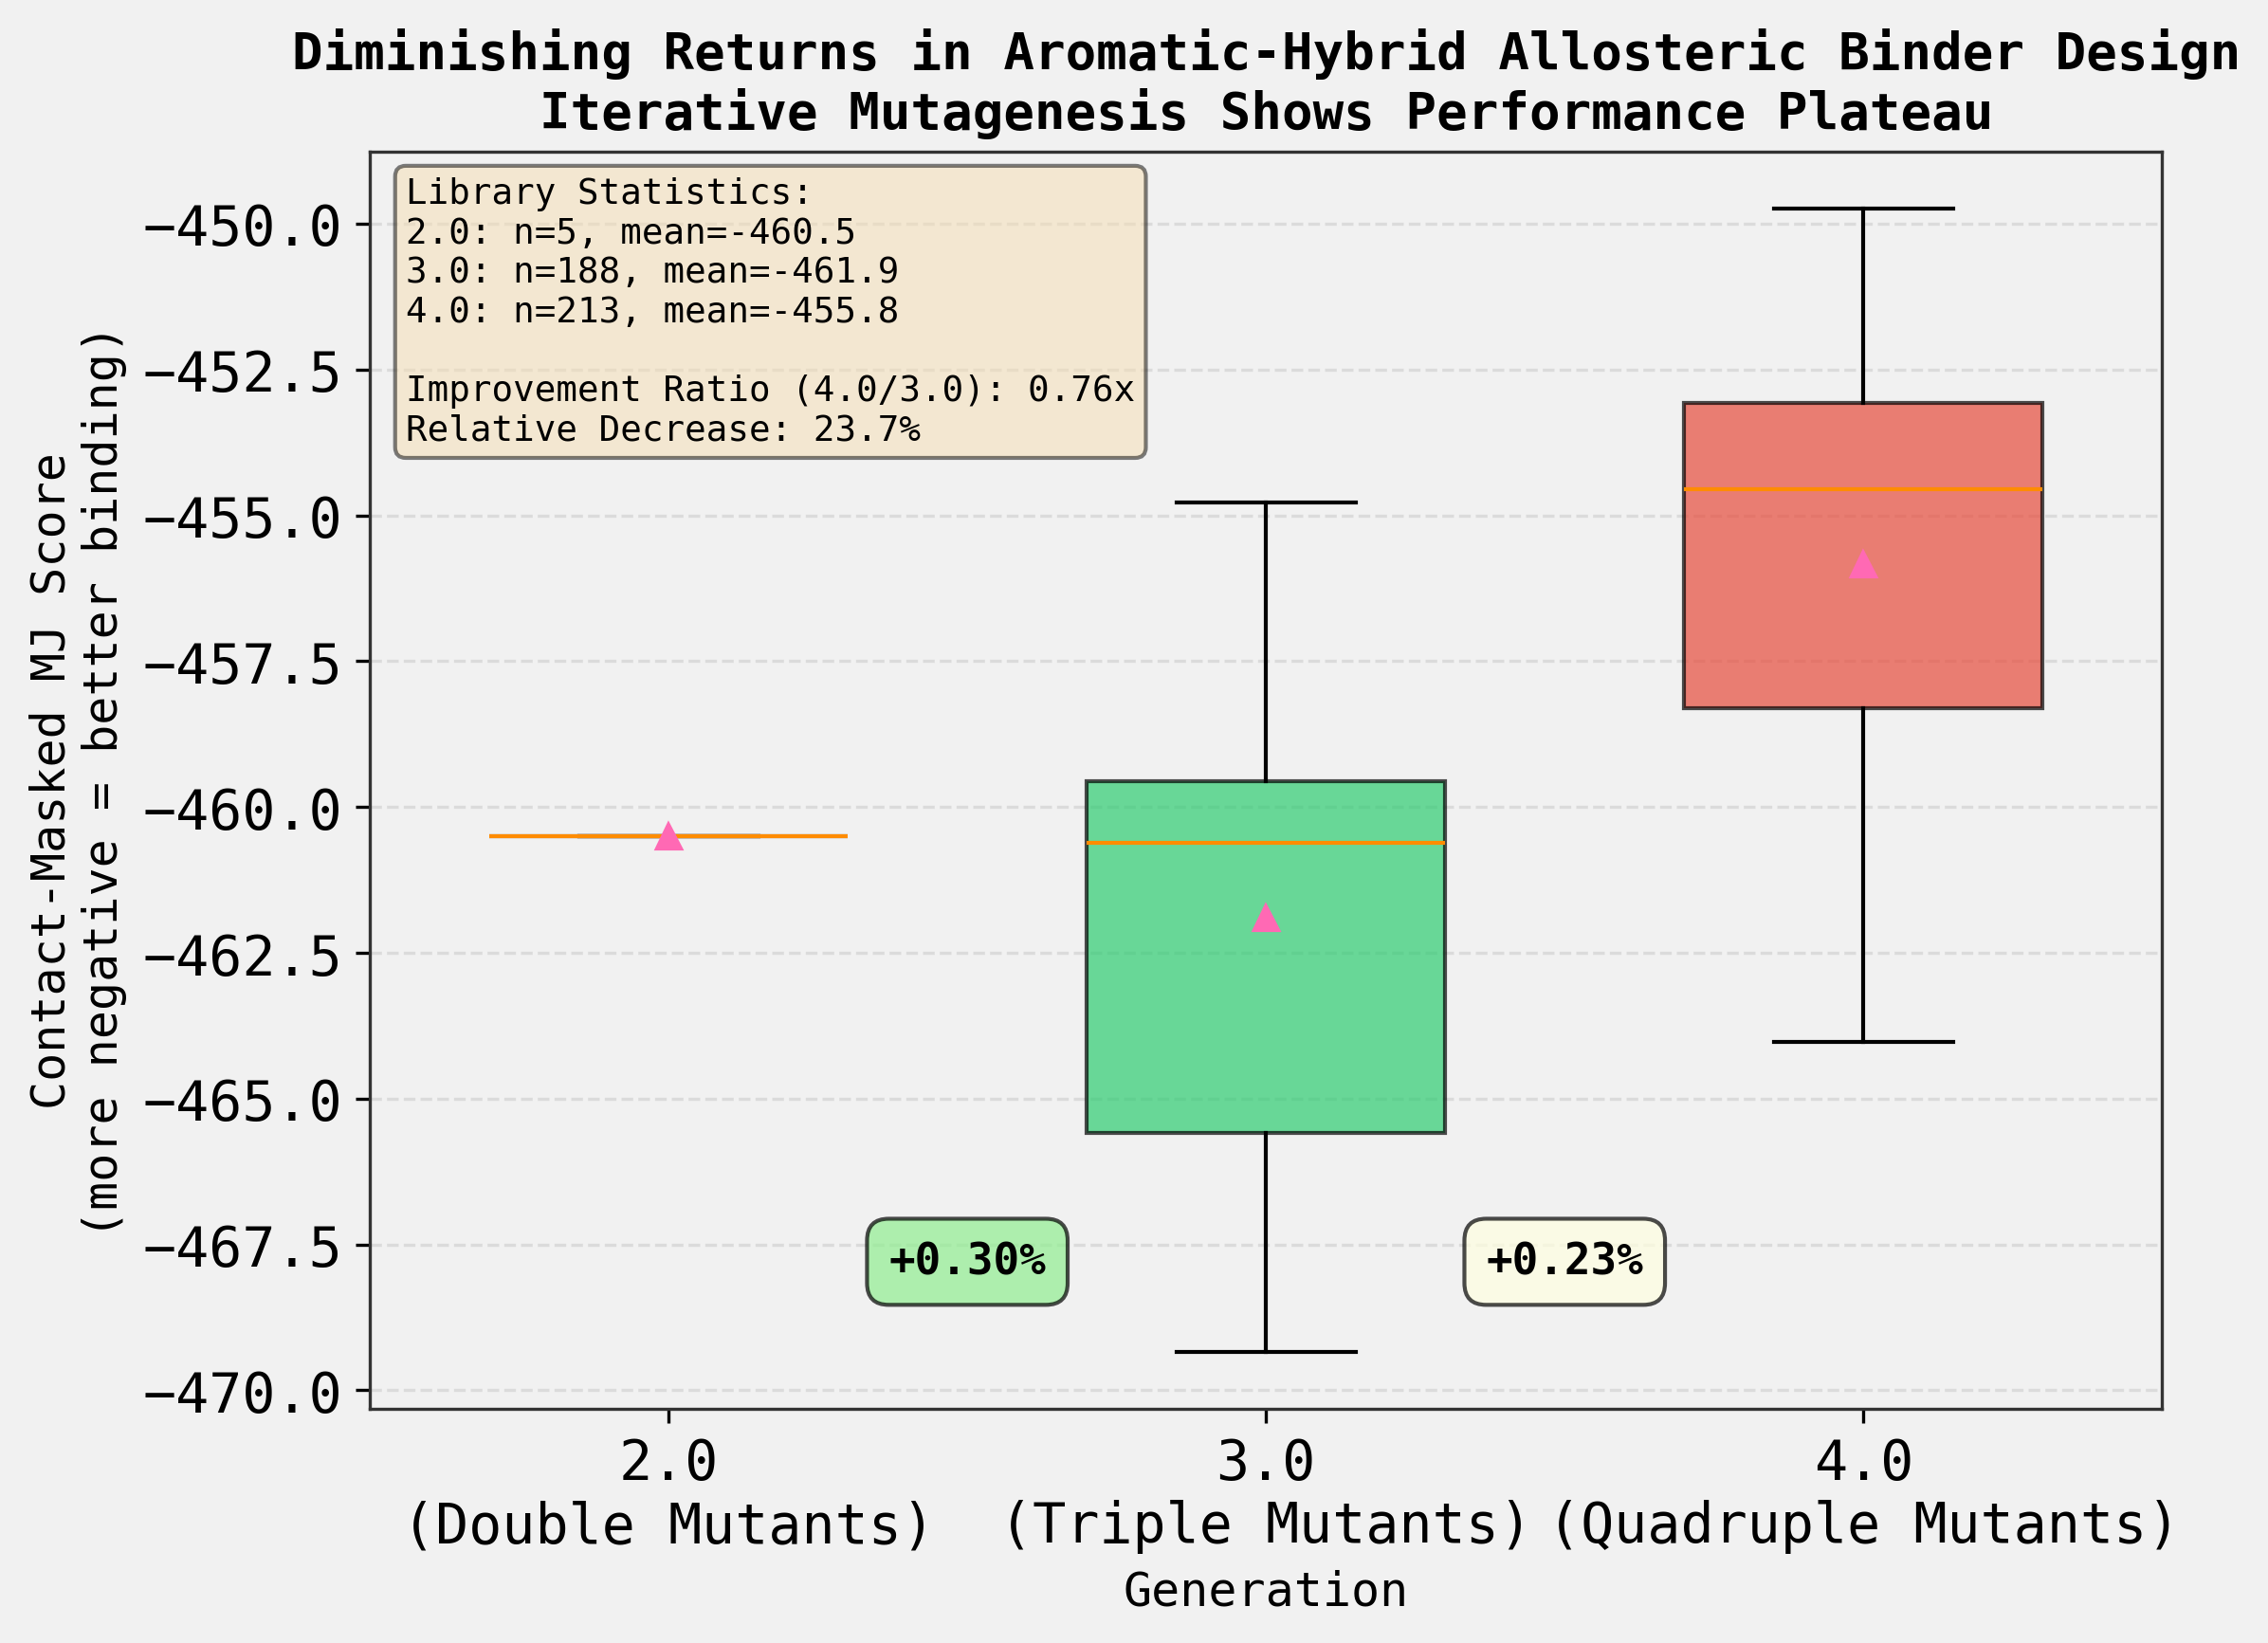

In [ ]:

# Create a final visualization comparing score distributions across generations
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Prepare data for visualization
scores_2_0 = list(motif_scores_2_0.values())
scores_3_0 = list(motif_scores_3_0.values())
scores_4_0 = list(motif_scores_4_0.values())

# Create box plot
box_data = [scores_2_0, scores_3_0, scores_4_0]
positions = [1, 2, 3]

bp = ax.boxplot(box_data, positions=positions, widths=0.6, 
                patch_artist=True, showmeans=True)

# Color the boxes
colors = ['#3498db', '#2ecc71', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add labels and formatting
ax.set_xticks(positions)
ax.set_xticklabels(['2.0\n(Double Mutants)', '3.0\n(Triple Mutants)', '4.0\n(Quadruple Mutants)'])
ax.set_ylabel('Contact-Masked MJ Score\n(more negative = better binding)', fontsize=12)
ax.set_xlabel('Generation', fontsize=12)
ax.set_title('Diminishing Returns in Aromatic-Hybrid Allosteric Binder Design\nIterative Mutagenesis Shows Performance Plateau', 
             fontsize=13, fontweight='bold')

# Add grid for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add text annotations showing mean improvements
improvement_2_to_3_text = f"+{improvement_2_to_3:.2f}%"
improvement_3_to_4_text = f"+{improvement_3_to_4:.2f}%"

ax.annotate(improvement_2_to_3_text, xy=(1.5, -468), ha='center', fontsize=11, 
            color='black', weight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

ax.annotate(improvement_3_to_4_text, xy=(2.5, -468), ha='center', fontsize=11, 
            color='black', weight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.7))

# Add summary statistics as text
stats_text = f"""Library Statistics:
2.0: n={len(scores_2_0)}, mean={np.mean(scores_2_0):.1f}
3.0: n={len(scores_3_0)}, mean={np.mean(scores_3_0):.1f}
4.0: n={len(scores_4_0)}, mean={np.mean(scores_4_0):.1f}

Improvement Ratio (4.0/3.0): {improvement_3_to_4/improvement_2_to_3:.2f}x
Relative Decrease: {((improvement_2_to_3 - improvement_3_to_4) / improvement_2_to_3) * 100:.1f}%"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('aromatic_hybrid_4.0_diminishing_returns.png', dpi=300, bbox_inches='tight')
print("Figure saved as 'aromatic_hybrid_4.0_diminishing_returns.png'")
plt.show()
